# 🧠 MSLesSeg 4 ICPR

Multimodal 3D Segmentation of Multiple Sclerosis Lesions using SegFormer3DMoE

    🚀 An end-to-end deep learning pipeline for segmenting sparse MS lesions in 3D MRI data using a modern, cloud-deployable architecture powered by PyTorch Lightning and Transformers.

---

## Table of contents

- [MSLesSeg Dataset Overview](#🧠-MSLesSeg-Dataset-Overview)
- [Exploring the Dataset Visually](#📊-1.-Exploring-the-Dataset-in-3D)
- [Designing the Dataset Class](#🧱-2.-Designing-the-Dataset-Class)
- [Building the Datamodule for Training](#📦-3.-Building-the-DataModule-for-Training)
- [Sanity Check: Visualizing Preprocessed Slices](🔍-4.-Sanity-Check:-Visualizing-Preprocessed-Slices)
- [Architecting SegFormer3DMoE](#🧠-5.-Architecting-SegFormer3DMoE)
- [Model Summary and Parameter Check](#📄-6.-Model-Summary-&-Parameter-Check)
- [Hybrid Loss Functions](#💔-7.-Hybrid-Loss-Functions)
- [Lightning Module Definition](#⚙️-8.-LightningModule-Definition)
- [Training the SegFormer3D Model](#🔥-9.-Training-the-SegFormer3D-Model)
- [Visualizing Inferences on Random Samples](#🧪-10.-Visual-Inference-on-Random-Samples)


---

## 🧠 MSLesSeg Dataset Overview

As part of this competition, participants were provided with the **MSLesSeg Dataset** — a **comprehensively annotated, multi-modal MRI dataset** designed for advancing **lesion segmentation** research in medical imaging.

### 📊 Dataset Composition
- **Total Patients:** 75 (48 women, 27 men)  
- **Age Range:** 18–59 years (Mean: 37 ± 10.3 years)  
- **Longitudinal Timepoints:**  
  - 50 patients with 1 timepoint  
  - 15 patients with 2 timepoints  
  - 5 patients with 3 timepoints  
  - 5 patients with 4 timepoints  
- **Time Interval Between Scans:** ~1.27 ± 0.62 years  
- **Total MRI Series:** 115

### 🧬 Imaging Modalities
Each timepoint includes **three core MRI modalities**:
- **T1-weighted (T1-w)**
- **T2-weighted (T2-w)**
- **FLAIR (Fluid-Attenuated Inversion Recovery)**

### 🧑‍⚕️ Expert Annotation
- Lesions were **manually annotated** by clinical experts.
- **FLAIR sequences** were the primary reference for lesion labeling.
- **T1-w and T2-w** scans supported **multi-contrast lesion characterization**.

### 🧪 Dataset Splits
- **Training Set:** 53 scans  
- **Test Set:** 22 scans  

### ✅ Ethical Compliance
- **Ethical approval** was obtained from the corresponding Hospital Ethics Committee.
- **Informed consent** was acquired from all participating patients.

---

# The Experiment

Below is the code used for the:

1) Preprocessing of the ***Brain MRI*** scans
2) Definition of Dataset, Dataloader and LihgtningDataModule classes
3) ***SegFormer3D*** architecture
4) ***PyTorch Lightning*** Trainer
5) Training & Evaluation
6) Model Exaplainability with the post-hoc method ***GradCam++***

---

## 🛠️ Preprocessing & Annotation Workflow

The MSLesSeg dataset underwent a **comprehensive preprocessing pipeline** and **expert-driven manual annotation** to ensure **standardization** and **label quality** for downstream MS lesion segmentation tasks.

### 🧼 Preprocessing Pipeline
1. **Anonymization** of all MRI scans to protect patient privacy.
2. **DICOM to NIfTI conversion**, leveraging NIfTI's wide adoption in neuroimaging.
3. **Co-registration to the MNI152 1mm³ isotropic template** using **FLIRT** (FMRIB’s Linear Image Registration Tool), ensuring all scans are aligned to a **common anatomical space**.
4. **Brain extraction** via **BET** (Brain Extraction Tool) to remove non-brain tissues and isolate relevant structures.

This pipeline guarantees that all images are **standardized** and **aligned**, which is critical for **automated MS lesion segmentation algorithms**.

---

### 🖋️ Ground-Truth Annotation Protocol
- Lesions were **manually segmented** on the **FLAIR modality** for each patient and timepoint.
- **T1-w and T2-w** modalities were used to **cross-validate ambiguous cases**.
- Annotation was conducted by a **trained junior rater**, under supervision of:
  - A **senior neuroradiologist**
  - A **senior neurologist**
- Annotation sessions included:
  - Multiple **training meetings** to establish a **consistent segmentation strategy**
  - Use of **JIM9** — a high-end tool for **medical image segmentation and analysis**
  - Regular **expert validation checkpoints** to ensure consistency and accuracy

The final masks, reviewed and approved by senior experts, are considered the **gold-standard ground truth**.

---

## 🧾 Key Annotation Highlights
- **Independent segmentation** for each patient/timepoint to avoid bias
- Conducted on **FLAIR scans registered to MNI space**
- **Validated ground-truth masks** ready for training and evaluation

---


# 📊 1. Exploring the Dataset in 3D

Visualizing the Raw MRI Volumes and Labels
Gain intuition about the data by visualizing multimodal MR images and the corresponding sparse lesion masks. This helps guide architectural and preprocessing choices.

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

def load_nifti(file_path):
    nii = nib.load(file_path)
    return nii.get_fdata()

def get_middle_slice(volume):
    z = volume.shape[2] // 2
    return volume[:, :, z]

def plot_modalities_with_segmentation(flair_path, t1_path, t2_path, seg_path):
    # Load volumes
    flair = load_nifti(flair_path)
    t1 = load_nifti(t1_path)
    t2 = load_nifti(t2_path)
    seg = load_nifti(seg_path)

    # Normalize intensities for better visualization
    def normalize(img):
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

    flair_norm = normalize(flair)
    t1_norm = normalize(t1)
    t2_norm = normalize(t2)

    # Get middle slices
    flair_slice = get_middle_slice(flair_norm)
    t1_slice = get_middle_slice(t1_norm)
    t2_slice = get_middle_slice(t2_norm)
    seg_slice = get_middle_slice(seg)

    modalities = [flair_slice, t1_slice, t2_slice]
    names = ["FLAIR", "T1", "T2"]

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    for i in range(3):
        # Row 1: original modality
        axs[0, i].imshow(modalities[i], cmap='gray')
        axs[0, i].set_title(f"{names[i]} - Middle Slice")
        axs[0, i].axis('off')

        # Row 2: overlay with segmentation mask
        axs[1, i].imshow(modalities[i], cmap='gray')
        axs[1, i].imshow(seg_slice, cmap='Reds', alpha=0.4)  # overlay
        axs[1, i].set_title(f"{names[i]} + Segmentation")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

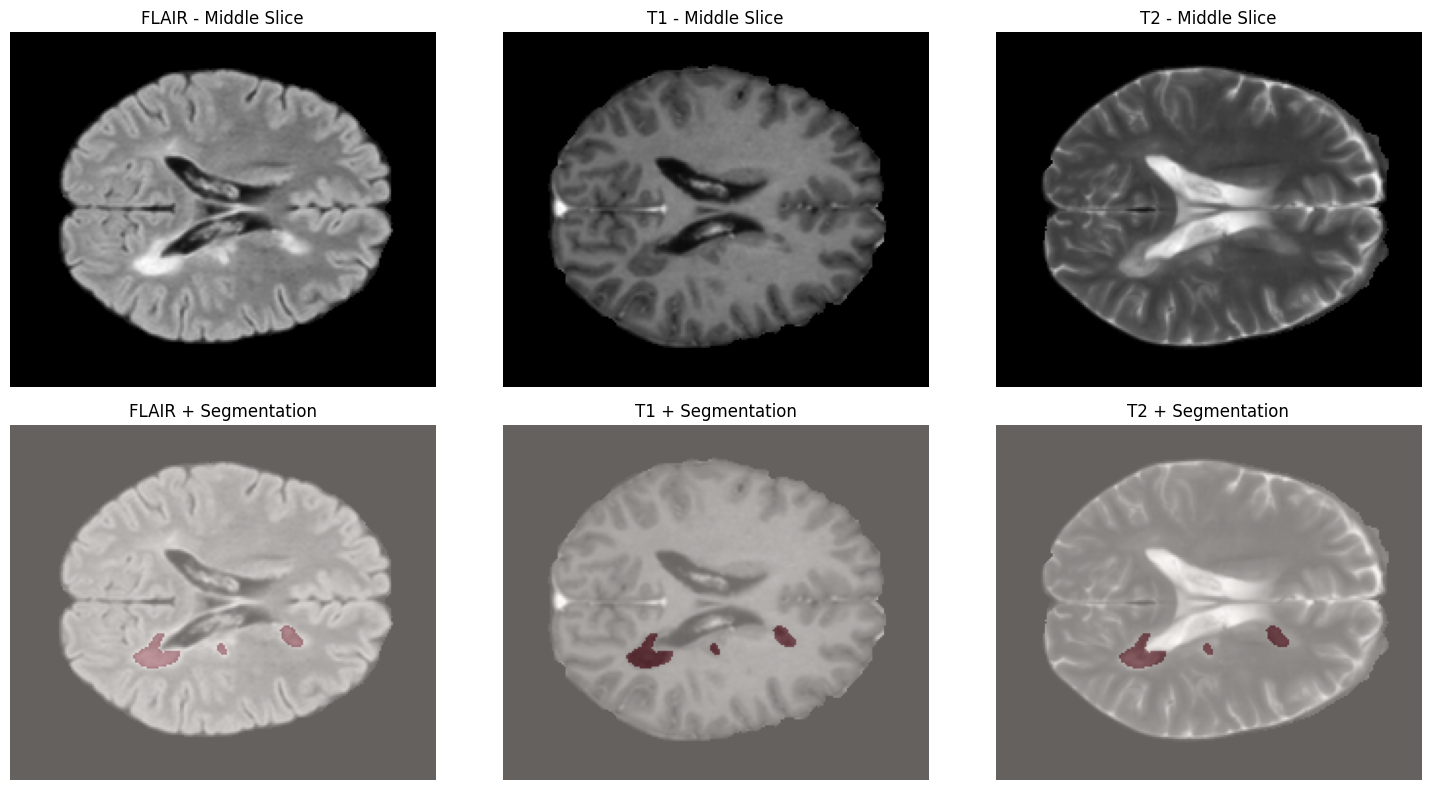

In [2]:
plot_modalities_with_segmentation(
    flair_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz",
    t1_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t1.nii.gz",
    t2_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t2.nii.gz",
    seg_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_seg.nii.gz"
)

---

As can be seen by the previous illustrations, the visualization of the data can be quite tricky, this is why developing reliable and high-quality ***Deep Learning*** architectures for ***Medical Imaging*** is paramount for the progress of the field in the medical realm

---

The following code shows all the details stored in the ***.nii.gz*** files of the ***Brain MRI*** scans

---

In [3]:
import nibabel as nib
import os
import numpy as np

def inspect_nifti_file(nii_path):
    if not os.path.exists(nii_path):
        print(f"File not found: {nii_path}")
        return

    img = nib.load(nii_path)
    data = img.get_fdata()
    affine = img.affine
    header = img.header

    print(f"Shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Voxel dimensions (zoom): {header.get_zooms()}")
    print(f"Affine matrix:\n{affine}")
    print(f"Min intensity: {np.min(data):.2f}")
    print(f"Max intensity: {np.max(data):.2f}")

In [4]:
for i in range(0, 10): 
    nii_path = f"../data/01-Pre-Processed-Data/train/MSLS_00{i}/MSLS_00{i}_flair.nii.gz"
    inspect_nifti_file(nii_path)
    print("\n\n\n")

Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 269.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 651.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 590.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity:

---

The following code shows that despite aligning the ***Brain MRI*** scans to the ***MNI152*** space with the ***FLIRT*** tool, they are physically stored in the ***LAS*** orientation

In order to guarantee compatibility with the model, and for better processing, they will be re-aligned to the ***RAS*** orientation

---

In [5]:
# Get the orientation codes of the Brain MRI data
import nibabel as nib
from nibabel.orientations import aff2axcodes

# Load your NIfTI file
img = nib.load("../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz")

# Get the affine matrix
affine = img.affine

# Get the orientation codes (e.g., RAS, LAS, LPI, etc.)
orientation = aff2axcodes(affine)

print(f"Image orientation: {orientation}")

Image orientation: ('L', 'A', 'S')


---

## Dataset Preprocessing

In this section we preprocess the data further in order to make it more ***friendly*** for the ***Deep Learning*** architecture to process, by applying:

1) ***Z-Scoring*** to align the intensity values of all scans
2) ***RAS re-orientation*** which is frequently used in ***Medical Imaging*** applications
3) ***Transverse Axis Swapping*** which is also commonly used in the same real of ***Computer Vision***

---

In [6]:
import os
import torch
import nibabel as nib
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
import numpy as np
import torch
import nibabel as nib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from monai.data import MetaTensor
from monai.transforms import (
    Orientation, 
    EnsureType,
)

class Preprocessor:
    def __init__(self):
        pass

    def normalize(self, x: np.ndarray) -> np.ndarray:
        """
        Min-max normalization to [0, 1]
        This method reshapes the input array to 2D, applies normalization, and reshapes back.
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Flatten the data to 2D (H*W*D, 1)
        original_shape = x.shape
        x_flat = x.reshape(-1, x.shape[-1])  # Reshape to (H*W*D, 1)
        
        # Apply normalization
        normalized_1D_array = scaler.fit_transform(x_flat)
        
        # Reshape back to the original data shape
        normalized_data = normalized_1D_array.reshape(original_shape)
        return normalized_data

    def load_nifti(self, filepath: Path):
        """ Load the .nii.gz file using nibabel and return the data and affine """
        img = nib.load(str(filepath))
        data = img.get_fdata()
        affine = img.affine
        return data, affine

    def preprocess_modality(self, data_fp: str, is_label: bool = False) -> np.ndarray:
        """
        Apply preprocess stage to the modality
        data_fp: directory to the modality
        is_label: whether it's a label (segmentation mask)
        """
        # Load data using nibabel
        data, affine = self.load_nifti(data_fp)

        # For labels (segmentation masks), do not normalize
        if is_label:
            # Binary mask does not need to be float64! For saving storage purposes!
            data = data.astype(np.uint8)

        else:
            # Normalize the image (for modalities like flair, t1, t2)
            data = self.normalize(data)

        
        # Add channel dimension (1, D, H, W)
        data = data[np.newaxis, ...]
        # For reorienting to RAS coordinate system, we need to apply affine matrix
        # Since we are now using nibabel, affine is already handled with the image
        data = MetaTensor(x=data, affine=affine)
        # For oreinting the coordinate system we need the affine matrix
        data = self.orient(data)
        # Detaching the meta values from the oriented array
        data = self.detach_meta(data)
        # data = self.crop_centered_nonzero_region_swapped(data)
        # Suppress the non-brain areas from the input tensor
        data = data[:, 16:176, 20:180, 10:170]
        
        return data

    def orient(self, x):
        # Orient the array to be in (Right, Anterior, Superior) scanner coordinate systems
        assert type(x) == MetaTensor
        return Orientation(axcodes="RAS")(x)

    def detach_meta(self, x):
        assert type(x) == MetaTensor
        return EnsureType(data_type="numpy", track_meta=False)(x)

    def crop_centered_nonzero_region_swapped(self, x, target_shape=(160, 160, 160)):
        """
        For input with shape (C, D, W, H), crop to target shape around non-zero region.
        """
        assert x.ndim == 4, f"Expected 4D input, got {x.shape}"
        c, d, w, h = x.shape
        td, tw, th = target_shape  # new order matches D, W, H
    
        # Union of non-zero across channels
        nonzero_mask = np.any(x > 0, axis=0)  # shape: (D, W, H)
        non_zero = np.array(np.where(nonzero_mask))  # indices for (D, W, H)
    
        if non_zero.shape[1] == 0:
            raise ValueError("Input appears to be all zeros.")
    
        # Min and max along each dimension
        min_d, max_d = np.min(non_zero[0]), np.max(non_zero[0])
        min_w, max_w = np.min(non_zero[1]), np.max(non_zero[1])
        min_h, max_h = np.min(non_zero[2]), np.max(non_zero[2])
    
        # Compute center
        center_d = (min_d + max_d) // 2
        center_w = (min_w + max_w) // 2
        center_h = (min_h + max_h) // 2
    
        def get_crop_bounds(center, size, max_dim):
            start = max(center - size // 2, 0)
            end = start + size
            if end > max_dim:
                end = max_dim
                start = max(end - size, 0)
            return start, end
    
        d_start, d_end = get_crop_bounds(center_d, td, d)
        w_start, w_end = get_crop_bounds(center_w, tw, w)
        h_start, h_end = get_crop_bounds(center_h, th, h)
    
        # Crop
        cropped = x[:, d_start:d_end, w_start:w_end, h_start:h_end]
    
        # Pad if needed
        pad_d = td - cropped.shape[1]
        pad_w = tw - cropped.shape[2]
        pad_h = th - cropped.shape[3]
    
        if pad_d > 0 or pad_w > 0 or pad_h > 0:
            padding = [
                (0, 0),  # channel dim
                (0, pad_d),
                (0, pad_w),
                (0, pad_h),
            ]
            cropped = np.pad(cropped, padding, mode='constant', constant_values=0)
    
        return cropped





    def preprocess_case(self, input_dir: Path, output_dir: Path, case_id: str):
        modalities = ['flair', 't1', 't2']
        stacked_modalities = []

        # Process each modality (flair, t1, t2)
        for mod in modalities:
            path = input_dir / f"{case_id}_{mod}.nii.gz"
            preprocessed = self.preprocess_modality(path, is_label=False)
            stacked_modalities.append(preprocessed)  # Collect modality data

        # Stack the modalities into a single tensor with shape (C, D, H, W)
        stacked_tensor = np.concatenate(stacked_modalities, axis=0)
        stacked_tensor.swapaxes(1, 3)
        input_tensor = torch.tensor(stacked_tensor, dtype=torch.float32)

        # Process the segmentation mask (label)
        seg_path = input_dir / f"{case_id}_seg.nii.gz"
        seg_data = self.preprocess_modality(seg_path, is_label=True)
        # Convert the segmentation mask into a PyTorch Tensor
        seg_data.swapaxes(1, 3)
        seg_tensor = torch.from_numpy(seg_data).type(torch.uint8)

        # Save the processed input and segmentation tensors
        output_case_dir = output_dir / case_id
        output_case_dir.mkdir(parents=True, exist_ok=True)
        torch.save(input_tensor, output_case_dir / "input_tensor.pt")
        torch.save(seg_tensor, output_case_dir / "seg_mask.pt")

In [8]:
# Define and instantiate the preprocessor class
pre = Preprocessor()

In [9]:
from pathlib import Path
from tqdm import tqdm

def run_preprocessing(root_path, output_path):
    input_path = Path(root_path)
    output_path = Path(output_path)

    # Get all case directories
    all_case_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    print(f"Found {len(all_case_dirs)} cases.")

    for case_dir in tqdm(all_case_dirs):
        case_id = case_dir.name  # e.g., MSLS_000
        output_case_path = output_path / case_id  # Define output path for each case

        # Check if the case has already been processed (e.g., output directory or file exists)
        if output_case_path.exists():
            print(f"✅ Skipping {case_id}, already processed.")
            continue  # Skip processing if the case already exists

        try:
            pre.preprocess_case(case_dir, output_path, case_id)
        except Exception as e:
            print(f"❌ Failed on {case_id}: {e}")

In [10]:
# Run the preprocessing on the training set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/train"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/train"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 93 cases.


100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 8620.53it/s]

✅ Skipping MSLS_019, already processed.
✅ Skipping MSLS_039, already processed.
✅ Skipping MSLS_059, already processed.
✅ Skipping MSLS_000, already processed.
✅ Skipping MSLS_001, already processed.
✅ Skipping MSLS_002, already processed.
✅ Skipping MSLS_003, already processed.
✅ Skipping MSLS_004, already processed.
✅ Skipping MSLS_005, already processed.
✅ Skipping MSLS_006, already processed.
✅ Skipping MSLS_007, already processed.
✅ Skipping MSLS_008, already processed.
✅ Skipping MSLS_009, already processed.
✅ Skipping MSLS_010, already processed.
✅ Skipping MSLS_011, already processed.
✅ Skipping MSLS_012, already processed.
✅ Skipping MSLS_013, already processed.
✅ Skipping MSLS_014, already processed.
✅ Skipping MSLS_015, already processed.
✅ Skipping MSLS_016, already processed.
✅ Skipping MSLS_017, already processed.
✅ Skipping MSLS_018, already processed.
✅ Skipping MSLS_020, already processed.
✅ Skipping MSLS_021, already processed.
✅ Skipping MSLS_022, already processed.


In [11]:
# Run the preprocessing on the test set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/test/test_MASK"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/test"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 22 cases.


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 6701.63it/s]

✅ Skipping MSLS_093, already processed.
✅ Skipping MSLS_094, already processed.
✅ Skipping MSLS_095, already processed.
✅ Skipping MSLS_096, already processed.
✅ Skipping MSLS_097, already processed.
✅ Skipping MSLS_098, already processed.
✅ Skipping MSLS_099, already processed.
✅ Skipping MSLS_100, already processed.
✅ Skipping MSLS_101, already processed.
✅ Skipping MSLS_102, already processed.
✅ Skipping MSLS_103, already processed.
✅ Skipping MSLS_104, already processed.
✅ Skipping MSLS_105, already processed.
✅ Skipping MSLS_106, already processed.
✅ Skipping MSLS_107, already processed.
✅ Skipping MSLS_108, already processed.
✅ Skipping MSLS_109, already processed.
✅ Skipping MSLS_110, already processed.
✅ Skipping MSLS_111, already processed.
✅ Skipping MSLS_112, already processed.
✅ Skipping MSLS_113, already processed.
✅ Skipping MSLS_114, already processed.


In [12]:
import torch
import os
import numpy as np
from torch.serialization import add_safe_globals

def inspect_pt_file(pt_path):
    if not os.path.exists(pt_path):
        print(f"File not found: {pt_path}")
        return

    # If you trust the file, allow numpy reconstruct
    add_safe_globals([np.core.multiarray._reconstruct])

    # Load the file with weights_only=False
    data = torch.load(pt_path, weights_only=False)

    if isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
        print(f"Tensor dtype: {data.dtype}")
    elif isinstance(data, dict):
        print("Loaded object is a dictionary.")
        for key, value in data.items():
            if isinstance(value, torch.Tensor):
                print(f"Key: {key}, Shape: {value.shape}, Dtype: {value.dtype}")
            else:
                print(f"Key: {key}, Type: {type(value)}")
    elif isinstance(data, np.ndarray):
        print(f"Loaded NumPy array with shape: {data.shape}, dtype: {data.dtype}")
    else:
        print(f"Loaded object is of type {type(data)}")

In [13]:
# Quickly inspect the preprocessed data to assess shape and type

In [14]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/input_tensor.pt"
inspect_pt_file(pt_path)

Tensor shape: torch.Size([3, 160, 160, 160])
Tensor dtype: torch.float32


In [15]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/seg_mask.pt"
inspect_pt_file(pt_path)

Tensor shape: torch.Size([1, 160, 160, 160])
Tensor dtype: torch.uint8


---

# 🧱 2. Designing the Dataset Class

Custom Dataset for Multimodal 3D MRI
Define a PyTorch-compatible Dataset that handles loading, normalizing, and preprocessing FLAIR, T1, T2 images and their segmentation masks.

---

In [1]:
# MSLesSeg Tensor Dataset class
import os
import glob
import torch
from torch.utils.data import Dataset

class MSLesSegDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patient_dirs = self._get_patient_dirs()

    def _get_patient_dirs(self):
        """
        Helper function to search for all patient directories within train/test directories.
        """
        patient_dirs = []
        
        # Get all patient directories within the root_dir (either train or test)
        for patient_dir in os.listdir(self.root_dir):
            patient_path = os.path.join(self.root_dir, patient_dir)
            
            # Make sure it's a directory
            if os.path.isdir(patient_path):
                # Check if both 'input_tensor.pt' and 'seg_mask.pt' exist
                input_tensor_path = os.path.join(patient_path, 'input_tensor.pt')
                seg_mask_path = os.path.join(patient_path, 'seg_mask.pt')
                
                if os.path.exists(input_tensor_path) and os.path.exists(seg_mask_path):
                    patient_dirs.append(patient_path)
        
        return patient_dirs

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: {'input': tensor, 'mask': tensor} for the requested sample.
        """
        patient_dir = self.patient_dirs[idx]
        
        # Load the input tensor and segmentation mask
        input_tensor = torch.load(os.path.join(patient_dir, 'input_tensor.pt'))  # Shape: [3, 182, 218, 182]
        seg_mask = torch.load(os.path.join(patient_dir, 'seg_mask.pt'))  # Shape: [1, 182, 218, 182]
        
        return input_tensor, seg_mask

---

# 📦 3. Building the DataModule for Training

PyTorch Lightning DataModule Integration
Encapsulate training, validation, and test data handling with a Lightning DataModule — ensuring clean separation of concerns and reproducibility.

---

In [2]:
# MSLesSeg (PyTorch) LightningDataModule definition
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

class MSLesSegDataModule(pl.LightningDataModule):
    
    def __init__(self, root_data_dir, batch_size, val_split, num_workers):
        """
        root_data_dir: Is the path to the train and test data
        """
        super().__init__()
        self.data_dir = root_data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Load full training dataset
        full_dataset = MSLesSegDataset(root_dir=os.path.join(self.data_dir, 'train'))

        # Split into train and val
        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])
        self.test_dataset = MSLesSegDataset(root_dir=os.path.join(self.data_dir, 'test'))
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)



---

# 🔍 4. Sanity Check: Visualizing Preprocessed Slices

Inspecting the Processed Inputs & Targets
Visually confirm that preprocessing (e.g., normalization, slicing, mask alignment) is correct by rendering sample slices and overlays.

---

In [18]:
TENSOR_PATH = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/input_tensor.pt"

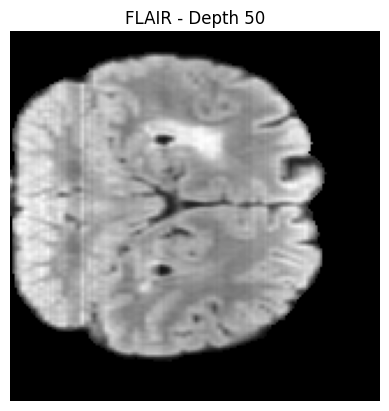

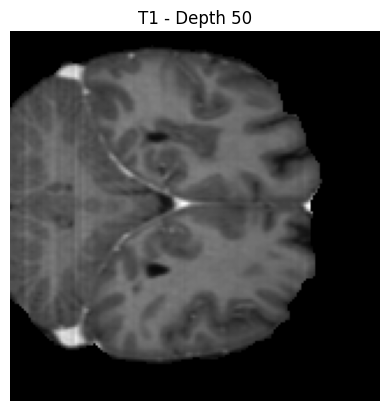

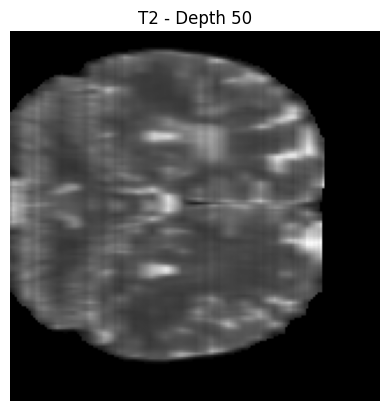

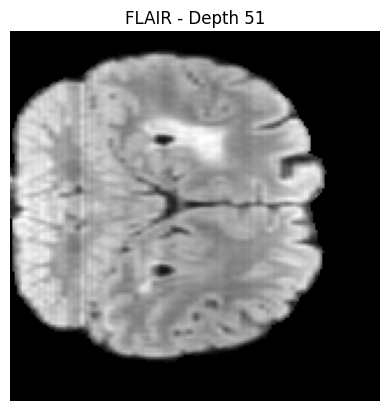

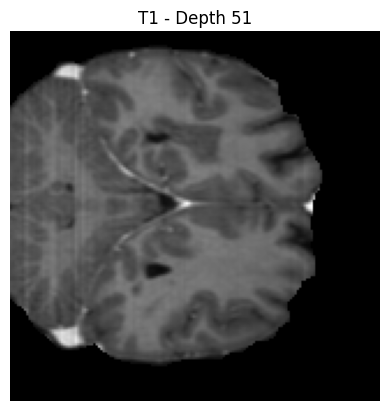

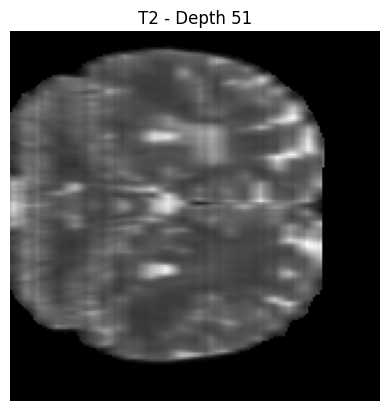

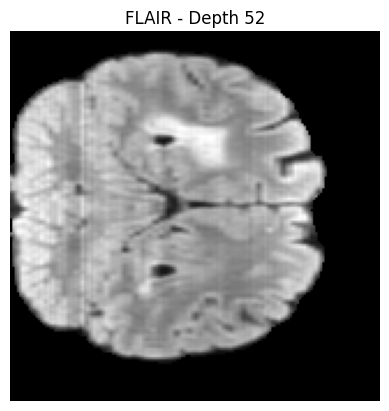

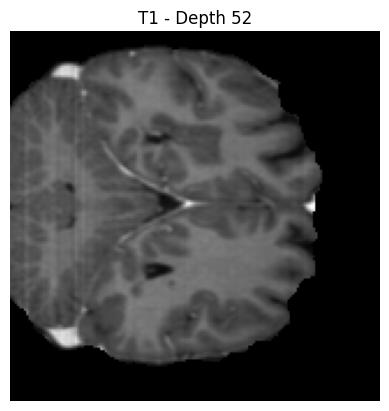

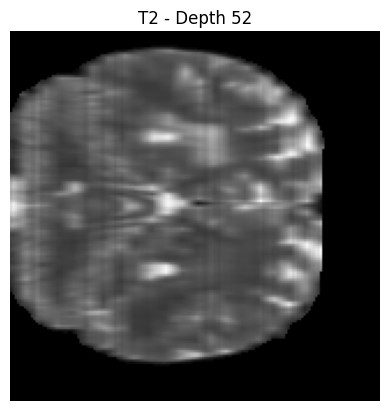

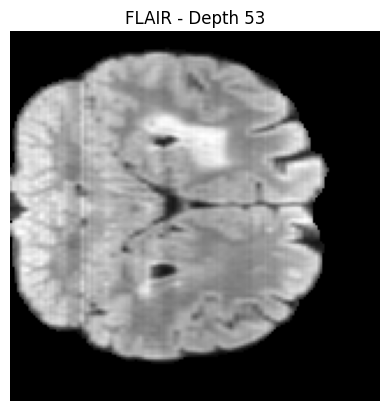

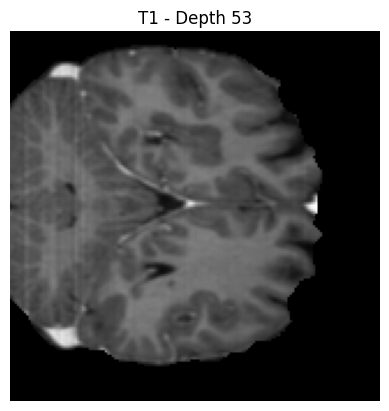

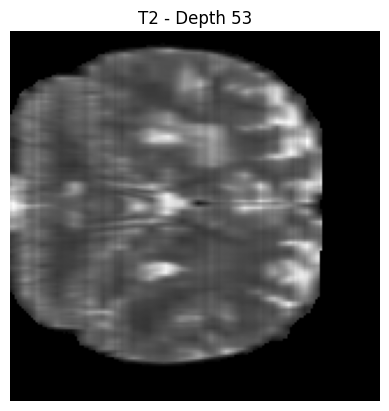

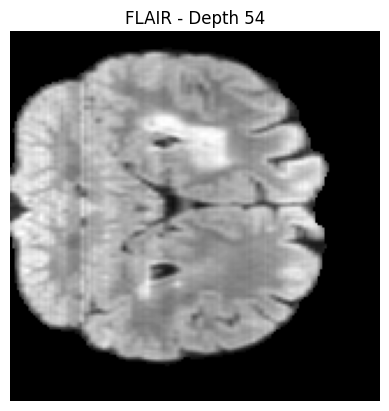

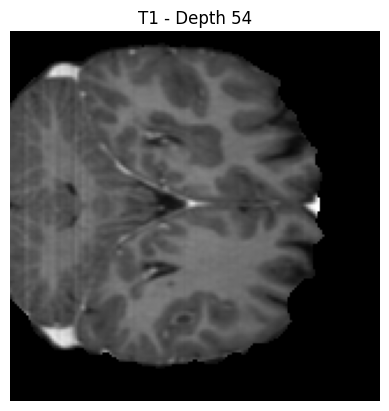

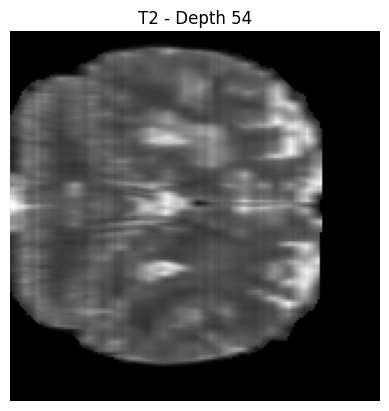

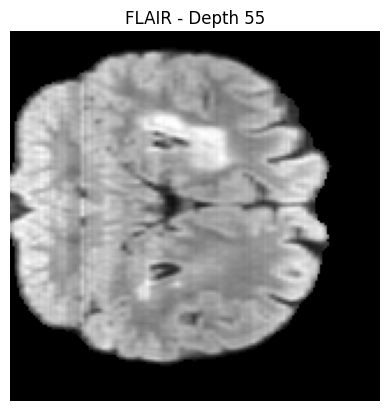

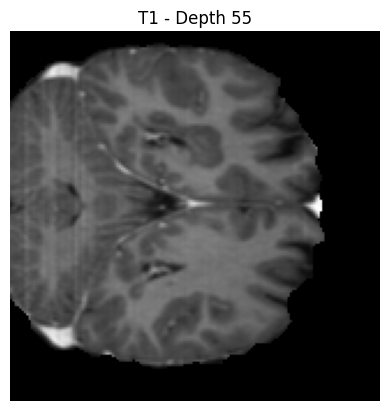

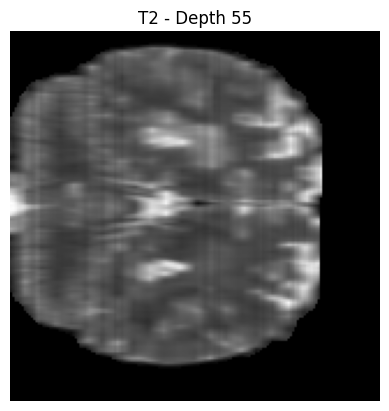

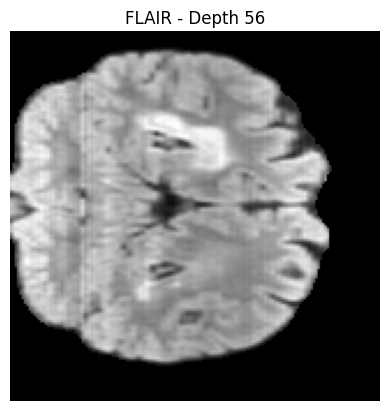

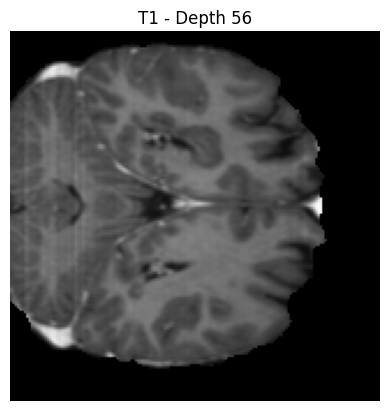

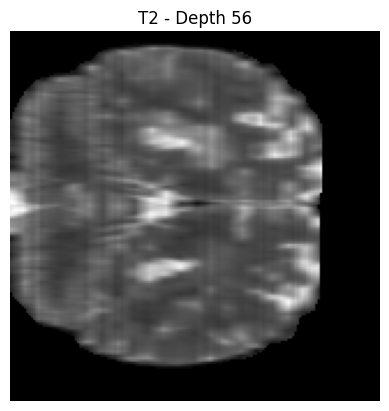

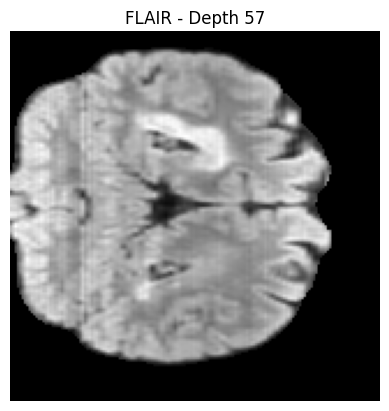

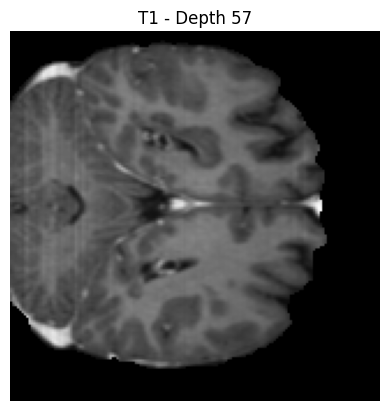

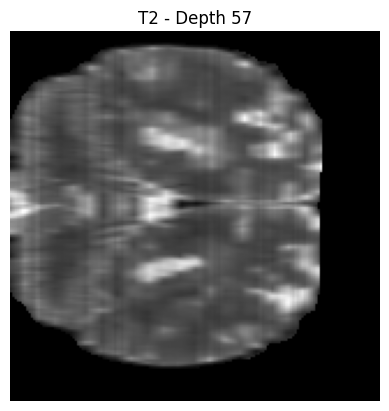

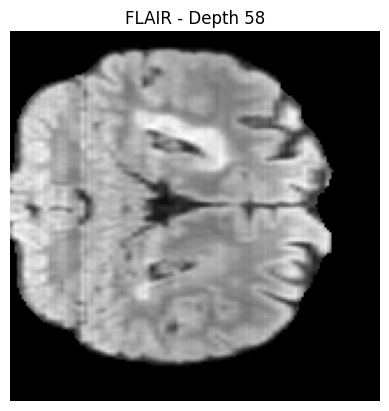

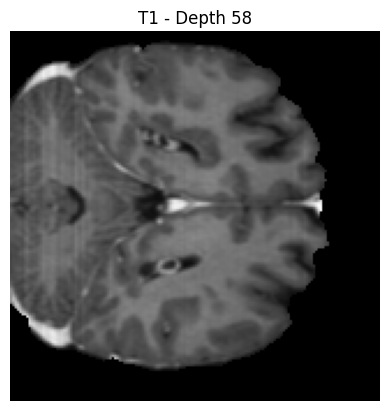

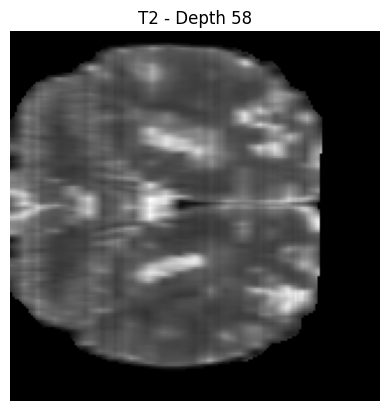

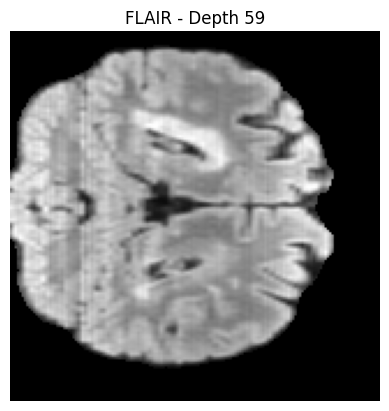

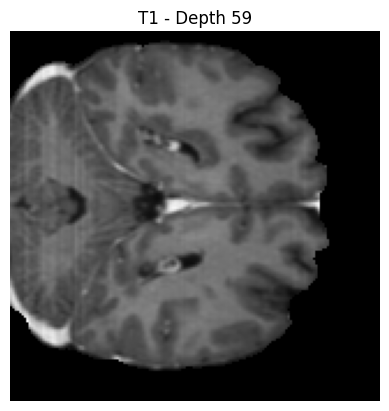

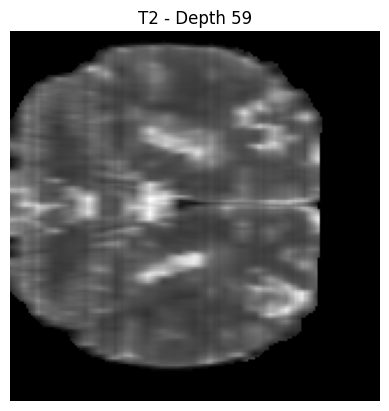

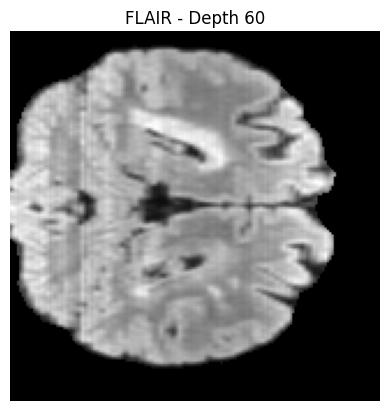

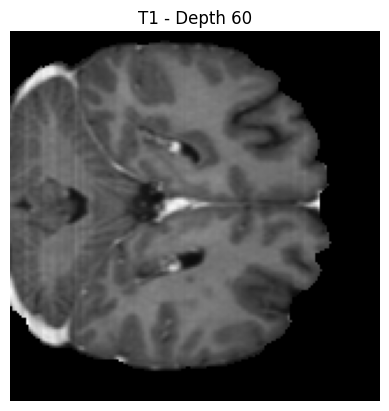

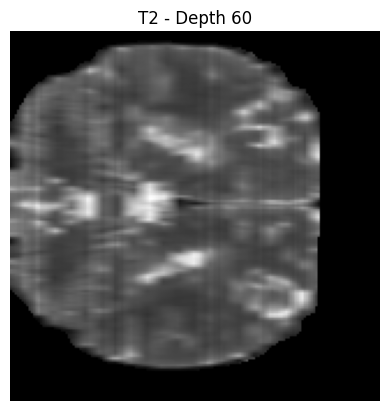

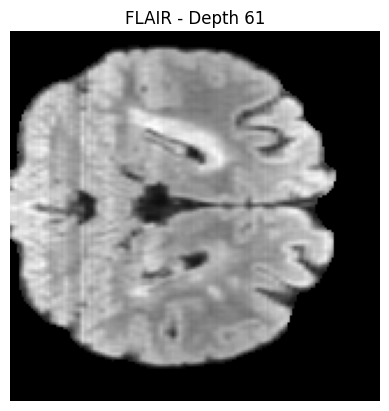

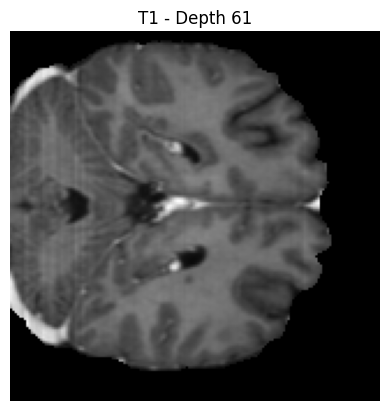

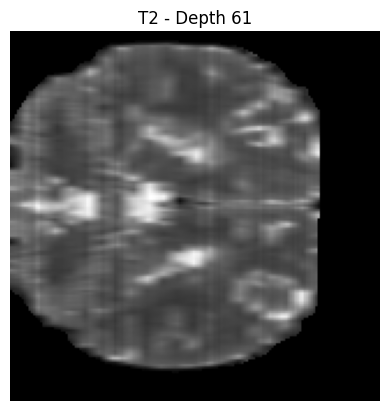

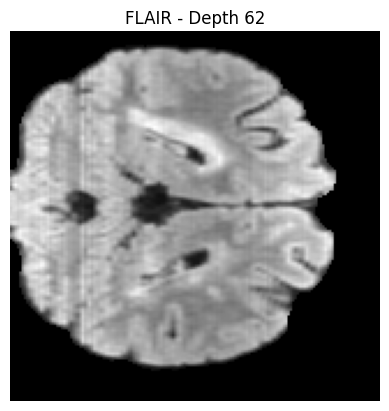

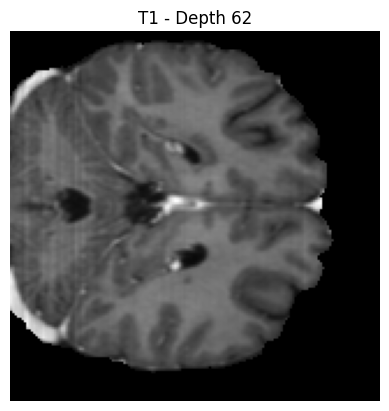

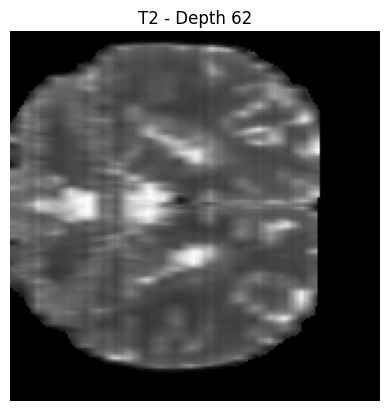

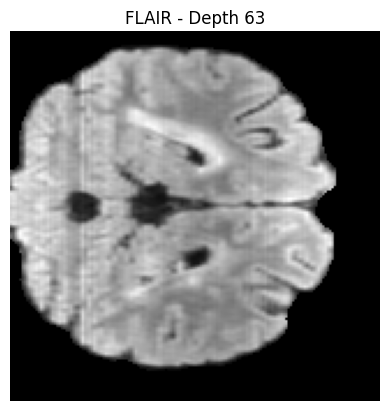

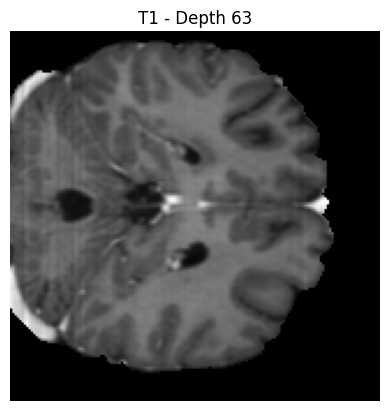

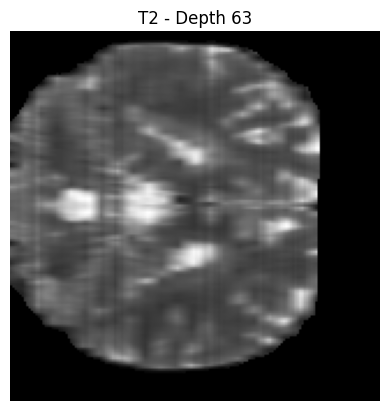

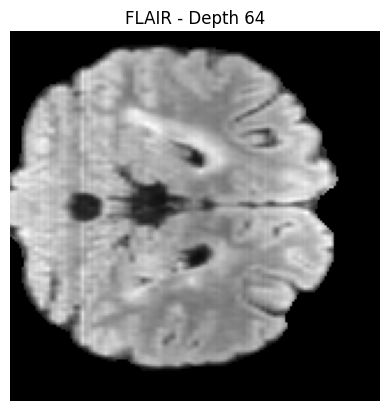

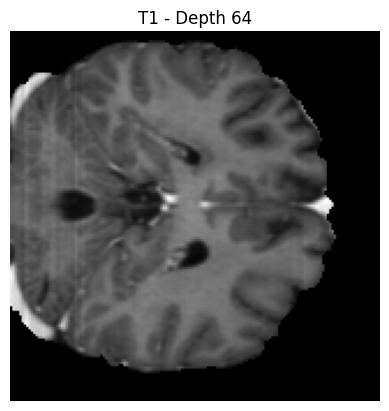

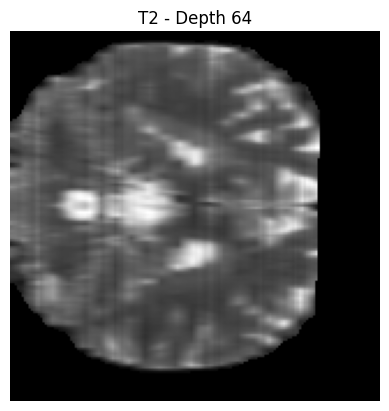

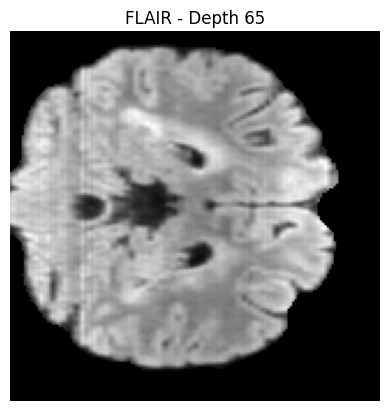

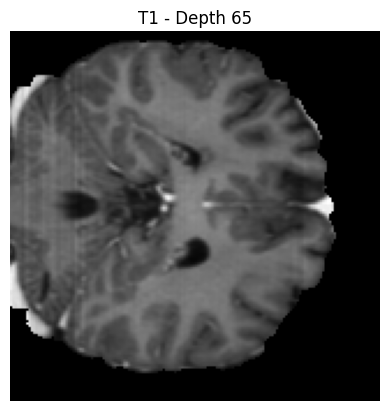

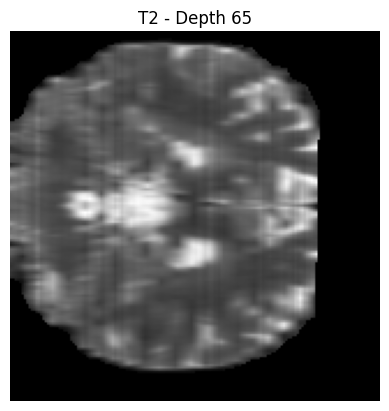

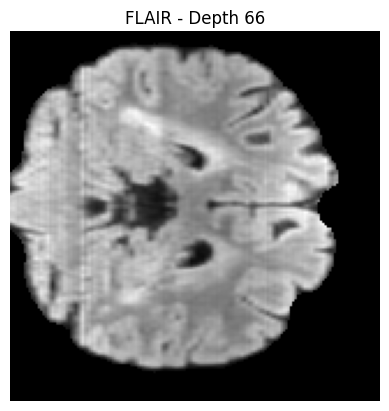

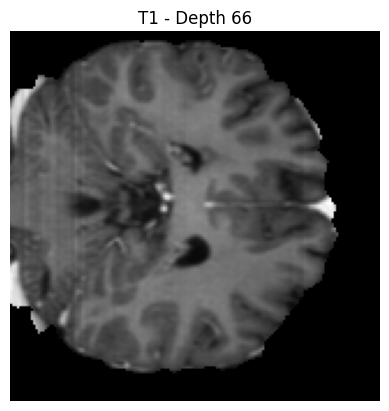

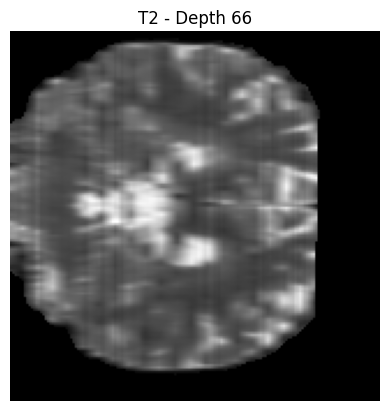

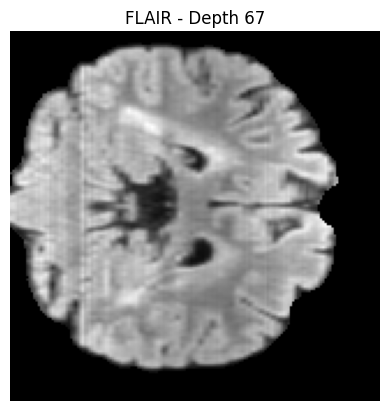

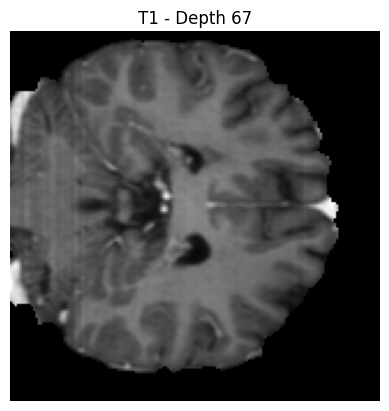

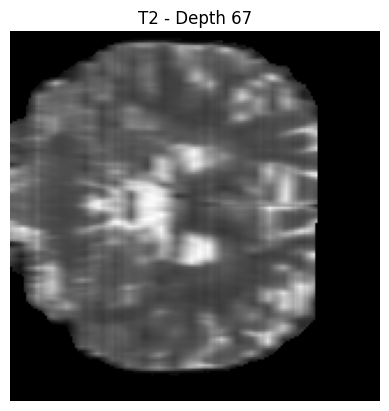

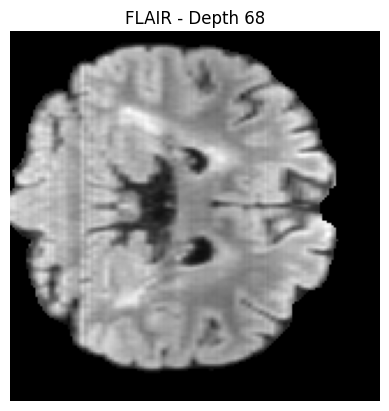

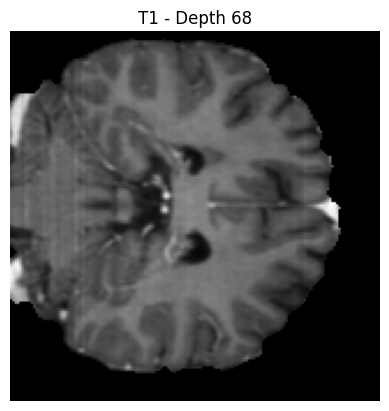

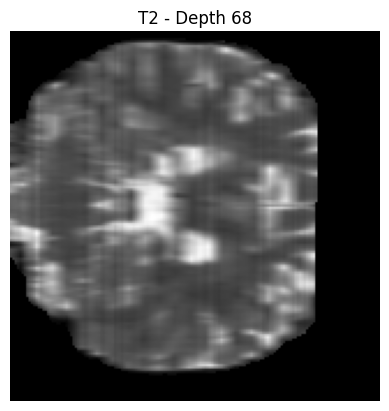

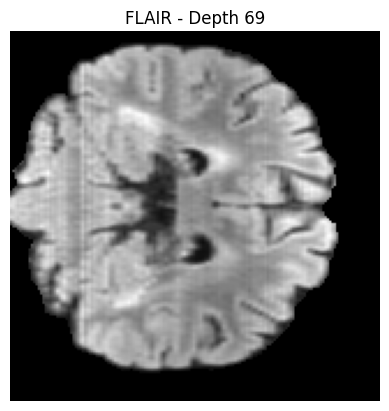

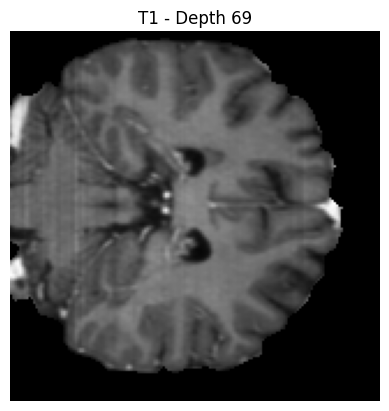

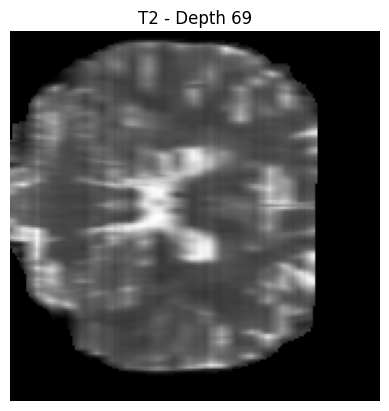

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the tensor is of shape [C, H, D, W] (3, 192, 192, 224)
# C = 3 (modalities), H = Height, D = Depth (number of slices), W = Width
tensor_path = TENSOR_PATH  # <-- Replace this with your tensor path
tensor = torch.load(tensor_path)

# Select the depth range to visualize
start_depth = 50  # starting slice along depth
end_depth = 70    # ending slice along depth

# Function to display slices
def show_slices(tensor, start_depth, end_depth):
    for depth in range(start_depth, end_depth):
        for channel in range(tensor.shape[0]):  # Loop through modalities (C channels)
            # Extract a slice from a specific modality (channel) and depth
            slice_data = tensor[channel, :, depth, :].cpu().numpy()  # Channel, All Height, Depth, Width
            modality_name = ['FLAIR', 'T1', 'T2'][channel]  # Map channel index to modality name
            plt.imshow(slice_data, cmap='gray', vmin=slice_data.min(), vmax=slice_data.max())
            plt.title(f"{modality_name} - Depth {depth}")
            plt.axis('off')
            plt.show()

# Display the slices for the selected depth range
show_slices(tensor, start_depth, end_depth)

---

# 🧠 5. Architecting SegFormer3DMoE

The Vision Transformer Backbone for 3D Segmentation
Introduce the custom SegFormer3DMoE model adapted for 3D volumetric data, integrating ViT-based encoders with MoE (Mixture of Experts) enhancements if applicable.

---

In [3]:
import math
import copy

from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, reduce


class SegFormer3DMoE(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        sr_ratios: list = [4, 2, 1, 1],
        embed_dims: list = [32, 64, 160, 256],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],
        num_experts_list: list = [4, 4, 6, 8],
        experts_selected_list: list = [2, 2, 3, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 1,
        encoder_dropout: float = 0.0,
        decoder_dropout: float = 0.0,
        moe_dropout_encoder: float = 0.0,
        moe_dropout_decoder: float = 0.0

    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increases the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps

        """
        super().__init__()

        # MoE Specific Losses to avoid unpacking issues in the code
        self.total_balance_loss = 0.0
        self.total_router_z_loss = 0.0

        # -- SegFormer3D Encoder -- #
        self.segformer_encoder = MixVisionTransformerMoE(
            in_channels=in_channels,
            sr_ratios=sr_ratios,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_experts_list=num_experts_list,
            experts_selected_list=experts_selected_list,
            num_heads=num_heads,
            depths=depths,
            encoder_dropout=encoder_dropout,
            moe_encoder_dropout=moe_dropout_encoder
        )

        # decoder takes in the feature maps in the reversed order
        reversed_embed_dims = embed_dims[::-1]

        # -- SegFormer3D Decoder -- #
        self.segformer_decoder = SegFormerDecoderHeadMoE(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
            moe_decoder_dropout=moe_dropout_decoder
            # TODO ---> There is a Static number of experts in the decoder!
        )


        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Conv3d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()


    def forward(self, x):
        # embedding the input
        
        x, total_encoder_balance_loss, total_encoder_router_z_loss = self.segformer_encoder(x)
        
        
        # # unpacking the embedded features generated by the transformer
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        
        # decoding the embedded features
        x, total_decoder_balance_loss, total_decoder_router_z_loss = self.segformer_decoder(c1, c2, c3, c4)

        # Internally store the MoE specific losses ot avoid unpacking errors
        self.total_encoder_balance_loss = total_encoder_balance_loss
        self.total_encoder_router_z_loss = total_encoder_router_z_loss 
        
        self.total_decoder_balance_loss = total_decoder_balance_loss
        self.total_decoder_router_z_loss = total_decoder_router_z_loss

        return x

    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # standard embedding patch
        patches = self.patch_embeddings(x)
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches


class SelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        assert (
            embed_dim % num_heads == 0
        ), "Embedding dim should be divisible by number of heads!"

        self.num_heads = num_heads
        # embedding dimesion of each attention head
        self.attention_head_dim = embed_dim // num_heads

        # The same input is used to generate the query, key, and value,
        # (batch_size, num_patches, hidden_size) -> (batch_size, num_patches, attention_head_size)
        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key_value = nn.Linear(embed_dim, 2 * embed_dim, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv3d(
                embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio
            )
            self.sr_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, hidden_size)
        B, N, C = x.shape

        # (batch_size, num_head, sequence_length, embed_dim)
        q = (
            self.query(x)
            .reshape(B, N, self.num_heads, self.attention_head_dim)
            .permute(0, 2, 1, 3)
        )

        if self.sr_ratio > 1:
            n = cube_root(N)
            # (batch_size, sequence_length, embed_dim) -> (batch_size, embed_dim, patch_D, patch_H, patch_W)
            x_ = x.permute(0, 2, 1).reshape(B, C, n, n, n)
            # (batch_size, embed_dim, patch_D, patch_H, patch_W) -> (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            # (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio) -> (batch_size, sequence_length, embed_dim)
            # normalizing the layer
            x_ = self.sr_norm(x_)
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x_)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)
        else:
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)

        k, v = kv[0], kv[1]

        attention_score = (q @ k.transpose(-2, -1)) / math.sqrt(self.num_heads)
        attnention_prob = attention_score.softmax(dim=-1)
        attnention_prob = self.attn_dropout(attnention_prob)
        out = (attnention_prob @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_dropout(out)
        return out


class TransformerBlockMoE(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_ratio: int = 2,
        num_experts: int = 8, 
        num_selected: int = 4,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        moe_encoder_dropout: float = 0.0
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        mlp_ratio: at which rate increasse the projection dim of the embedded patch in the _MLP component
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            sr_ratio=sr_ratio,
            qkv_bias=qkv_bias,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLPMoE(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=moe_encoder_dropout, num_experts=num_experts, num_selected=num_selected)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        processed_x, balance_loss, router_z_loss = self.mlp(self.norm2(x))
        x = x + processed_x
        return x, balance_loss, router_z_loss

class MixVisionTransformerMoE(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        sr_ratios: list = [8, 4, 2, 1],
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_experts_list: list = [4, 4, 6, 8],
        experts_selected_list: list = [2, 2, 3, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        encoder_dropout: float = 0.0,
        moe_encoder_dropout: float = 0.0
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratio: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depth: number of attention layers
        """
        super().__init__()

        # patch embedding at different Pyramid level
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],# -- SegFormer3D Encoder -- #
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    num_experts=num_experts_list[0],
                    num_selected=experts_selected_list[0],
                    sr_ratio=sr_ratios[0],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                    num_experts=num_experts_list[1],
                    num_selected=experts_selected_list[1],
                    sr_ratio=sr_ratios[1],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    num_experts=num_experts_list[2],
                    num_selected=experts_selected_list[2],
                    sr_ratio=sr_ratios[2],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    num_experts=num_experts_list[3],
                    num_selected=experts_selected_list[3],
                    sr_ratio=sr_ratios[3],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # Declare the initial values of the accumulated losses for every transformer block #

        # Balance Loss #
        total_balance_loss_blk_1 = 0.0
        total_balance_loss_blk_2 = 0.0
        total_balance_loss_blk_3 = 0.0
        total_balance_loss_blk_4 = 0.0

        # Router Z Loss #
        total_router_z_loss_blk_1 = 0.0
        total_router_z_loss_blk_2 = 0.0
        total_router_z_loss_blk_3 = 0.0
        total_router_z_loss_blk_4 = 0.0


        # stage 1
        x = self.embed_1(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block1):
            x, balance_loss_blk_1, router_z_loss_blk_1 = blk(x)
            total_balance_loss_blk_1 += balance_loss_blk_1
            total_router_z_loss_blk_1 += router_z_loss_blk_1

        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x = self.embed_2(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block2):
            x, balance_loss_blk_2, router_z_loss_blk_2 = blk(x)
            total_balance_loss_blk_2 += balance_loss_blk_2
            total_router_z_loss_blk_2 += router_z_loss_blk_2
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x = self.embed_3(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block3):
            x, balance_loss_blk_3, router_z_loss_blk_3 = blk(x)
            total_balance_loss_blk_3 += balance_loss_blk_3
            total_router_z_loss_blk_3 += router_z_loss_blk_3
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x = self.embed_4(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block4):
            x, balance_loss_blk_4, router_z_loss_blk_4 = blk(x)
            total_balance_loss_blk_4 += balance_loss_blk_4
            total_router_z_loss_blk_4 += router_z_loss_blk_4
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)


        # Accumulate the various balance and router_z losses from each transformer block
        total_balance_loss = total_balance_loss_blk_1 + total_balance_loss_blk_2 + total_balance_loss_blk_3 + total_balance_loss_blk_4
        total_router_z_loss = total_router_z_loss_blk_1 + total_router_z_loss_blk_2 + total_router_z_loss_blk_3 + total_router_z_loss_blk_4

        # Normalize the accumulated losses to avoid numerical instability and incorrectness
        normalized_total_balance_loss = total_balance_loss / 4
        normalized_total_router_z_loss = total_router_z_loss / 4


        # Attempt at changing the outputs in order to see if I don't break the sliding window inference
        return out, normalized_total_balance_loss, normalized_total_router_z_loss



class _MLPMoE(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.4, num_experts=8, num_selected=4):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.num_experts = num_experts
        self.num_selected = num_selected

        # Gating network
        self.gate = nn.Linear(in_feature, num_experts, bias=False)

        # Expert networks (each one replicates your original MLP structure)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_feature, out_feature),
                DWConv(dim=out_feature),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(out_feature, in_feature),
                nn.Dropout(dropout),
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        B, L, C = x.shape  # (Batch, Sequence Length, Channels)

        # Gating logic
        gate_logits = self.gate(x)  # (B, L, E)

        # Router z-loss
        router_z_loss = torch.logsumexp(gate_logits, dim=-1)
        router_z_loss = torch.square(router_z_loss).mean()

        # Softmax on last dim to get gating probabilities
        gate_softmax = F.softmax(gate_logits, dim=-1, dtype=torch.float).to(x.dtype)

        # Balance proxy
        density_1_proxy = reduce(gate_softmax, '... e -> e', 'mean')

        # Top-k expert selection
        weights, selected_experts = torch.topk(gate_softmax, self.num_selected, dim=-1)  # (B, L, k)

        # One-hot encoding to track expert usage
        one_hot_gate_indices = F.one_hot(rearrange(selected_experts, '... k -> k ...'), self.num_experts).float()[0]
        density_1 = reduce(one_hot_gate_indices, '... e -> e', 'mean')

        # Balance loss for encouraging uniform expert use
        balance_loss = (density_1_proxy * density_1).mean() * float(self.num_experts ** 2)

        # Normalize weights
        weights = weights / torch.sum(weights, dim=-1, keepdim=True).to(x.dtype)

        # Prepare output tensor
        results = torch.zeros_like(x)

        # Route each token to its selected experts
        for i, expert in enumerate(self.experts):
            for b in range(B):  # batch loop
                token_idx, nth_expert = torch.where(selected_experts[b] == i)

                if token_idx.numel() == 0:
                    continue

                input_to_expert = x[b][token_idx]  # shape: (N, C)

                # Reshape to match expert input expectation
                if input_to_expert.dim() == 1:
                    input_to_expert = input_to_expert.unsqueeze(0).unsqueeze(0)
                elif input_to_expert.dim() == 2:
                    input_to_expert = input_to_expert.unsqueeze(0)  # shape: (1, N, C)

                output = expert(input_to_expert)  # shape: (1, N, C)
                output = output.squeeze(0)  # shape: (N, C)

                # Weighted addition to output
                results[b][token_idx] += weights[b][token_idx, nth_expert, None] * output
    
        return results, balance_loss, router_z_loss




class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv_1d = nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)
        self.dwconv_3d = nn.Conv3d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, N, C = x.shape
        n = round(N ** (1 / 3))

        if n ** 3 == N:
            x = x.transpose(1, 2).view(B, C, n, n, n)
            x = self.dwconv_3d(x)
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.transpose(1, 2)
            x = self.dwconv_1d(x)
            x = x.transpose(1, 2)

        x = self.norm(x)
        return x



def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    


# TODO ---> Adapt the MLPMoE layer to replace the MLP_ class !!!!! <--------

# ----------------------------------------------------- decoder -------------------
class MLPMoE(nn.Module):
    def __init__(self, num_experts, num_selected, mm_channels, channels, num_layers, dropout):
        super().__init__()
        self.num_experts = num_experts
        self.num_selected = num_selected
        self.mm_channels = mm_channels
        self.channels = channels

        self.gate = nn.Linear(mm_channels, num_experts, bias=False)
        self.num_selected = num_selected
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(mm_channels, channels),
                    nn.Dropout(dropout),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(channels, channels)
                    ) for _ in range(num_experts)
                    ])

    def forward(self, x):
        """
        x: Tensor of shape [B, N, C] — same as output from MLP_ after flattening
        Returns: Tensor of shape [B, N, channels]
        """
        B, N, C = x.shape

        gate_logits = self.gate(x)  # [B, N, num_experts]
        router_z_loss = torch.logsumexp(gate_logits, dim=-1)
        router_z_loss = torch.square(router_z_loss).mean()

        gate_softmax = F.softmax(gate_logits, dim=-1, dtype=torch.float).to(x.dtype)

        density_1_proxy = gate_softmax.mean(dim=(0, 1))  # [num_experts]
        weights, selected_experts = torch.topk(gate_softmax, self.num_selected, dim=-1)  # [B, N, K]

        one_hot_gate_indices = F.one_hot(selected_experts, self.num_experts).float()  # [B, N, K, E]
        density_1 = one_hot_gate_indices.mean(dim=(0, 1))  # [num_experts]
        balance_loss = (density_1_proxy * density_1).mean() * float(self.num_experts ** 2)

        # [B, N, C] → process each token independently
        output = torch.zeros(B, N, self.channels, device=x.device, dtype=x.dtype)

        for i, expert in enumerate(self.experts):
            # Get mask of tokens that routed to expert i (anywhere in top-k)
            mask = (selected_experts == i)  # [B, N, K]
            token_mask = mask.any(dim=-1)  # [B, N]

            for b in range(B):
                selected = token_mask[b]  # [N], bool
                if selected.any():
                    expert_input = x[b][selected]  # [T_i, C]
                    expert_output = expert(expert_input)  # [T_i, channels]

                    # distribute outputs by averaging across k if multiple
                    weight_sum = weights[b][selected]  # [T_i, K]
                    weight_sum = weight_sum[mask[b][selected]].view(-1, 1)  # [T_i*K_used, 1]

                    output[b][selected] += expert_output * weight_sum.mean(dim=1, keepdim=True)

        return output, balance_loss, router_z_loss



class SegFormerDecoderHeadMoE(nn.Module):
    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
        num_experts: int = 4,
        num_selected: int = 2,
        moe_decoder_dropout: float = 0.0
    ):
        super().__init__()

        self.linear_c4 = MLPMoE(num_experts, num_selected, input_feature_dims[0], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c3 = MLPMoE(num_experts, num_selected, input_feature_dims[1], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c2 = MLPMoE(num_experts, num_selected, input_feature_dims[2], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c1 = MLPMoE(num_experts, num_selected, input_feature_dims[3], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)

        self.linear_fuse = nn.Sequential(
            nn.Conv3d(4 * decoder_head_embedding_dim, decoder_head_embedding_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout(dropout)
        self.linear_pred = nn.Conv3d(decoder_head_embedding_dim, num_classes, kernel_size=1)
        self.upsample_volume = nn.Upsample(scale_factor=4.0, mode="trilinear", align_corners=False)

    def forward(self, c1, c2, c3, c4):
        n, _, d, h, w = c4.shape

        moe_outputs = []
        moe_losses = []

        def process_moe_input(cX, moe_layer):
            B, C, D, H, W = cX.shape
            x = cX.flatten(2).transpose(1, 2)  # → [B, N, C]
            out, bal_loss, z_loss = moe_layer(x)
            out = out.transpose(1, 2).reshape(B, -1, D, H, W)  # back to [B, C, D, H, W]
            return out, bal_loss, z_loss


        _c4, bal4, z4 = process_moe_input(c4, self.linear_c4)
        _c4 = F.interpolate(_c4, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c3, bal3, z3 = process_moe_input(c3, self.linear_c3)
        _c3 = F.interpolate(_c3, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c2, bal2, z2 = process_moe_input(c2, self.linear_c2)
        _c2 = F.interpolate(_c2, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c1, bal1, z1 = process_moe_input(c1, self.linear_c1)

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)

        total_balance_loss = bal1 + bal2 + bal3 + bal4
        total_router_z_loss = z1 + z2 + z3 + z4

        total_balance_loss = total_balance_loss / 4
        total_router_z_loss = total_router_z_loss / 4

        return x, total_balance_loss, total_router_z_loss

---

# 📄 6. Model Summary & Parameter Check

Validating Model Build with Dummy Inputs
Run a forward pass with synthetic data and print the model summary using tools like torchinfo to ensure the architecture is built correctly and uses GPU memory efficiently.

---

In [21]:
# Output a brief summary of the model
from torchinfo import summary

# Create the model instance
model = SegFormer3DMoE(
    in_channels = 3,
    sr_ratios = [4, 2, 1, 1],
    embed_dims = [32, 64, 160, 256],
    patch_kernel_size = [7, 3, 3, 3],
    patch_stride = [4, 2, 2, 2],
    patch_padding = [3, 1, 1, 1],
    mlp_ratios = [4, 4, 4, 4],
    num_experts_list = [4, 4, 6, 8],
    experts_selected_list = [2, 2, 3, 4],
    num_heads = [1, 2, 5, 8],
    depths = [2, 2, 2, 2],
    decoder_head_embedding_dim = 256,
    num_classes = 1,
    encoder_dropout = 0.0,
    decoder_dropout = 0.0,
    moe_dropout_encoder = 0.0,
    moe_dropout_decoder = 0.0
)

# Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Show model summary
summary(model, input_size=(1, 3, 160, 160, 160), device=str(device))

Layer (type:depth-idx)                                       Output Shape              Param #
SegFormer3DMoE                                               [1, 1, 160, 160, 160]     --
├─MixVisionTransformerMoE: 1-1                               [1, 32, 40, 40, 40]       --
│    └─PatchEmbedding: 2-1                                   [1, 64000, 32]            --
│    │    └─Conv3d: 3-1                                      [1, 32, 40, 40, 40]       32,960
│    │    └─LayerNorm: 3-2                                   [1, 64000, 32]            64
│    └─ModuleList: 2-2                                       --                        --
│    │    └─TransformerBlockMoE: 3-3                         [1, 64000, 32]            120,928
│    │    └─TransformerBlockMoE: 3-4                         [1, 64000, 32]            120,928
│    └─LayerNorm: 2-3                                        [1, 64000, 32]            64
│    └─PatchEmbedding: 2-4                                   [1, 8000, 64]       

---

# 💔 7. Hybrid Loss Functions

Combining Dice & Cross-Entropy with MoE Regularization
Define modular loss functions (like DiceCELoss), ensuring proper optimization signals.

---

In [22]:
# Definition for the loss functions
from typing import Dict


import torch
import monai
import torch.nn as nn
from monai import losses



class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, predictions, targets):
        loss = self._loss(predictions, targets)
        return loss


class BinaryCrossEntropyWithLogits(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, predictions, tragets):
        loss = self._loss(predictions, tragets)
        return loss


class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceLoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss

class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceCELoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss

---

# ⚙️ 8. LightningModule Definition

Packaging the Model, Optimizer, Loss, and Scheduler
Use PyTorch Lightning’s LightningModule to manage the entire training pipeline — including optimizer, learning rate scheduler (e.g., CosineAnnealingLR), and checkpointing.


---

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class SegFormer3DMoETrainer(pl.LightningModule):
    def __init__(self, model,
                 checkpoint_dir,
                 saved_model_name,
                 lr=3e-4,
                 weight_decay=1e-2
                ):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.save_dir = checkpoint_dir
        self.lr = lr
        self.weight_decay = weight_decay
        self._dice_loss = DiceLoss()
        self._dice_ce_loss = DiceCELoss()
        self.checkpointed_model = saved_model_name

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        train_loss = self._dice_ce_loss(y_pred, y)

        # Use carefully chosen weights to avoid instability
        balance_weight = 1e-2
        router_z_weight = 1e-3
    
        # Weighted auxiliary losses
        encoder_balance = balance_weight * self.model.total_encoder_balance_loss
        encoder_router_z = router_z_weight * self.model.total_encoder_router_z_loss
        decoder_balance = balance_weight * self.model.total_decoder_balance_loss
        decoder_router_z = router_z_weight * self.model.total_router_z_loss
    
        # === Total loss ===
        total_train_loss = (
            train_loss +
            encoder_balance +
            encoder_router_z +
            decoder_balance +
            decoder_router_z
        )

        self.log("train_loss", total_train_loss, prog_bar=True, on_epoch=True, on_step=False)
        return total_train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = self._dice_ce_loss(y_pred, y)
        dice_score = (1 - self._dice_loss(y_pred, y))

        # Use carefully chosen weights to avoid instability
        balance_weight = 1e-2
        router_z_weight = 1e-3
    
        # Weighted auxiliary losses
        encoder_balance = balance_weight * self.model.total_encoder_balance_loss
        encoder_router_z = router_z_weight * self.model.total_encoder_router_z_loss
        decoder_balance = balance_weight * self.model.total_decoder_balance_loss
        decoder_router_z = router_z_weight * self.model.total_router_z_loss
    
        # === Total loss ===
        total_val_loss = (
            val_loss +
            encoder_balance +
            encoder_router_z +
            decoder_balance +
            decoder_router_z
        )    
        
        self.log("val_loss", total_val_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("dice_score", dice_score, prog_bar=True, on_epoch=True, on_step=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        test_loss = self._dice_ce_loss(y_pred, y)
        dice_score = (1 - self._dice_loss(y_pred, y))
        
        # Use carefully chosen weights to avoid instability
        balance_weight = 1e-2
        router_z_weight = 1e-3
    
        # Weighted auxiliary losses
        encoder_balance = balance_weight * self.model.total_encoder_balance_loss
        encoder_router_z = router_z_weight * self.model.total_encoder_router_z_loss
        decoder_balance = balance_weight * self.model.total_decoder_balance_loss
        decoder_router_z = router_z_weight * self.model.total_router_z_loss
    
        # === Total loss ===
        total_test_loss = (
            test_loss +
            encoder_balance +
            encoder_router_z +
            decoder_balance +
            decoder_router_z
        )  

        self.log("test_loss", total_test_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("dice_score_test", dice_score, prog_bar=True, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay, betas=(0.9, 0.95))
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            # T_max=60,
            T_0=5,
           T_mult=2,
            eta_min=1e-6
            # eta_min=self.lr # Use default learning rate
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or "step" if you're using per-step scheduling
                "monitor": None,      # if you're using ReduceLROnPlateau, set a metric here
            },
        }

    def on_train_epoch_end(self):
        os.makedirs(self.save_dir, exist_ok=True)
        save_path = os.path.join(self.save_dir, self.checkpointed_model)
    
        # Access the optimizer
        optimizer = self.trainer.optimizers[0]
        
        # Check if the scheduler exists and is set
        scheduler = self.trainer.lr_schedulers[0]['scheduler'] if hasattr(self.trainer, 'lr_schedulers') and self.trainer.lr_schedulers else None
    
        checkpoint = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'learning_rate': self.lr,
        }
    
        with open(save_path, 'wb') as f:
            torch.save(checkpoint, f)
            f.flush()
            os.fsync(f.fileno())



---

# 🔥 9. Training the SegFormer3DMoE Model

Launching the End-to-End Training
Kick off training with Trainer.fit() using all the pieces: model, data, loss, logging, and hardware accelerators (e.g., mixed precision, multiple GPUs, etc.).

---

In [24]:
# Register a free account with Weights and Biases, and create a new project in order to obtain an API Key for the training
import os
from dotenv import load_dotenv
import wandb

# Load the .env file
load_dotenv()

# Get the API key from the env variable
api_key = os.getenv("WANDB_API_KEY")

# Login to wandb
if api_key:
    os.environ["WANDB_API_KEY"] = api_key
    wandb.login()
else:
    print("❌ WANDB_API_KEY not found in .env file.")

wandb: Currently logged in as: drnnrw00m10c351s (fpv-perceivelab-unict) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [25]:
# Setup the Weights and Biases logger
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(
    project='MSLesSeg-4-ICPR',     # Change to your actual project name
    name='segformer3d_moe_run_5', # A specific run name
    log_model=True          # Optional: log model checkpoints
)

In [26]:
# Set the constant for the maximum number of epochs for the training
MAX_EPOCHS = 400

In [27]:
# Definition of Dataloader hyperparameters (Batch size, seed and num workers)
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

TRAIN_NUM_WORKERS = 0
TEST_NUM_WORKERS = 0

TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = 1
TEST_BATCH_SIZE = 2

In [28]:
# Create the Trainer object
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu",
    # precision=32,
    logger=wandb_logger,
    log_every_n_steps=9999999,
    benchmark=False,  # optimize CUDA kernels for performance
    detect_anomaly=False,
    gradient_clip_val=1.0 # Gradient clipping for stability
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
# Prepare the data module
data_module = MSLesSegDataModule(
    root_data_dir="../data/03-SegFormer-Tensor-Data/",
    batch_size=TRAIN_BATCH_SIZE,
    val_split=VAL_SPLIT,
    num_workers=TRAIN_NUM_WORKERS
)

In [30]:
# Instantiate the model
segformer3dmoe = SegFormer3DMoE(
    in_channels = 3,
    sr_ratios = [4, 2, 1, 1],
    embed_dims = [32, 64, 160, 256],
    patch_kernel_size = [7, 3, 3, 3],
    patch_stride = [4, 2, 2, 2],
    patch_padding = [3, 1, 1, 1],
    mlp_ratios = [4, 4, 4, 4],
    num_experts_list = [2, 2, 4, 4],
    experts_selected_list = [1, 1, 2, 2],
    num_heads = [1, 2, 5, 8],
    depths = [2, 2, 2, 2],
    decoder_head_embedding_dim = 256,
    num_classes = 1,
    encoder_dropout = 0.05,
    decoder_dropout = 0.05,
    moe_dropout_encoder = 0.05,
    moe_dropout_decoder = 0.05
)

In [31]:
# Instantiate the PyTorch Lightning Module (wrapper for the PyTorch nn.Module ~ Architecture)
lightning_model = SegFormer3DMoETrainer(
    model=segformer3dmoe,
    checkpoint_dir="./model_checkpoints",
    saved_model_name="segformer3d_moe_best_model_5.pth"
)

/home/drew/miniconda3/envs/mslesseg4icpr/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [32]:
# Train (fit) the model
trainer.fit(lightning_model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | model         | SegFormer3DMoE | 10.8 M | train
1 | _dice_loss    | DiceLoss       | 0      | train
2 | _dice_ce_loss | DiceCELoss     | 0      | train
---------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.273    Total estimated model params size (MB)
489       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/drew/miniconda3/envs/mslesseg4icpr/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/drew/miniconda3/envs/mslesseg4icpr/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/drew/miniconda3/envs/mslesseg4icpr/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=9999999). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [33]:
# Evaluate the model on the test set
trainer.test(lightning_model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/drew/miniconda3/envs/mslesseg4icpr/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     dice_score_test        0.47348204255104065
        test_loss           0.5932050347328186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5932050347328186, 'dice_score_test': 0.47348204255104065}]

---

# 🧪 10. Visual Inference on Random Samples

Visualizing Predicted Masks vs Ground Truth
Run inference on validation/test data and visualize how well the model segments tiny and sparse lesions, overlaying predicted vs. ground truth masks on MRI slices.

---

In [34]:
import torch
import random
import matplotlib.pyplot as plt

# For better display
import numpy as np

def load_trained_model(model_class, checkpoint_path):
    model = model_class
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [35]:
# Grab one random sample from the DataLoader
def get_random_sample(data_module):
    test_loader = data_module.test_dataloader()
    print(f"Test DataLoader:\t{test_loader}")
    all_samples = list(test_loader)  # may be inefficient for large datasets
    random_batch = random.choice(all_samples)
    inputs, targets = random_batch[0], random_batch[1]
    idx = random.randint(0, inputs.shape[0] - 1)
    return inputs[idx], targets[idx]

In [36]:
# Run inference
def predict(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor.unsqueeze(0))  # add batch dim
        if isinstance(output, (list, tuple)):
            output = output[0]
        prediction = torch.argmax(output.squeeze(0), dim=0)  # remove batch, get class map
    return prediction

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_modalities_with_masks(input_tensor, prediction, ground_truth, modality_names=['FLAIR', 'T1', 'T2']):
    """
    input_tensor: torch.Tensor of shape (3, D, H, W)
    prediction: torch.Tensor of shape (1, D, H, W) or (D, H, W)
    ground_truth: torch.Tensor of shape (1, D, H, W) or (D, H, W)
    """
    # Convert tensors to numpy and squeeze extra channels
    input_np = input_tensor.cpu().numpy()
    pred_mask = prediction.squeeze().cpu().numpy()
    gt_mask = ground_truth.squeeze().cpu().numpy()
    
    # Get middle slice index (axial view)
    z = input_np.shape[1] // 2  # shape: (3, D, H, W)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i in range(3):  # for each modality
        img = input_np[i, z, :, :]  # shape (H, W)

        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].imshow(pred_mask[z, :, :], cmap='jet', alpha=0.4)
        axes[0, i].set_title(f"{modality_names[i]} + Pred")
        axes[0, i].axis('off')

        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].imshow(gt_mask[z, :, :], cmap='jet', alpha=0.4)
        axes[1, i].set_title(f"{modality_names[i]} + GT")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

Test DataLoader:	<torch.utils.data.dataloader.DataLoader object at 0x7fc1902df650>


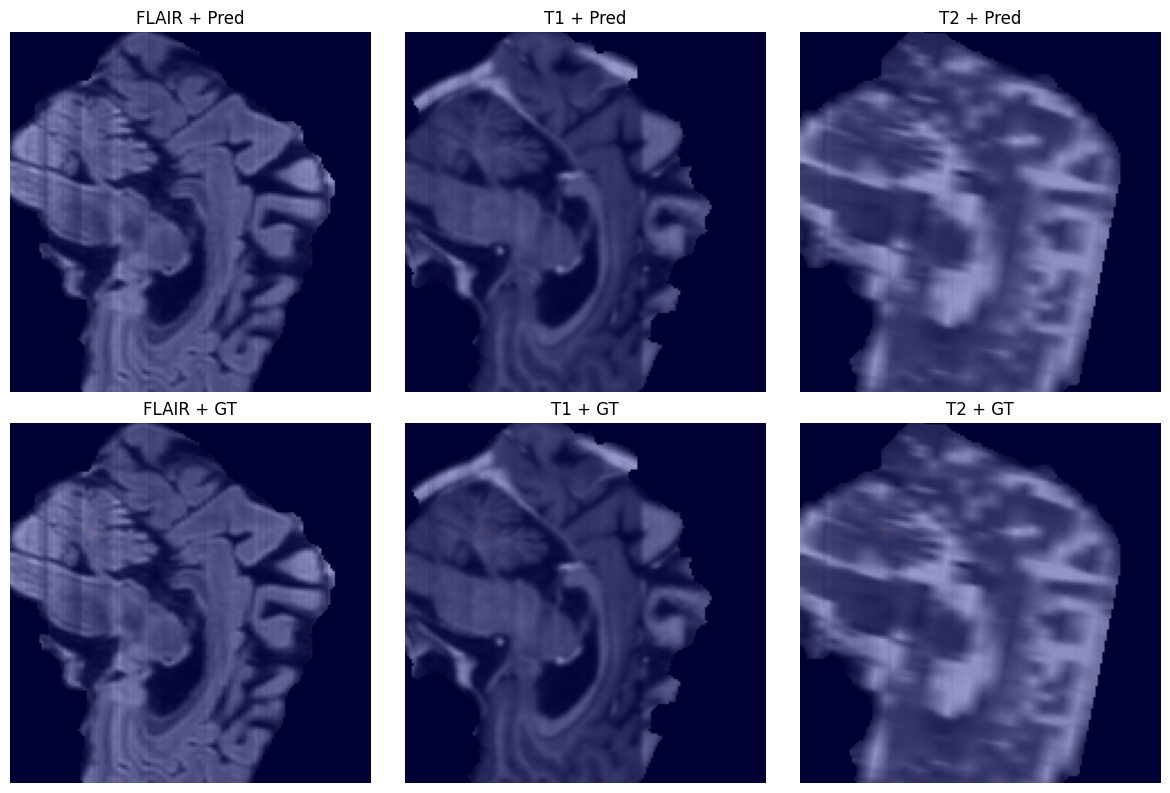

In [38]:
# Load the trained model
model = load_trained_model(segformer3dmoe, "./model_checkpoints/segformer3d_moe_best_model_5.pth")

# Get random sample
input_tensor, ground_truth = get_random_sample(data_module)

# Get prediction
prediction = predict(model, input_tensor)

# Plot results
plot_modalities_with_masks(input_tensor, prediction, ground_truth)

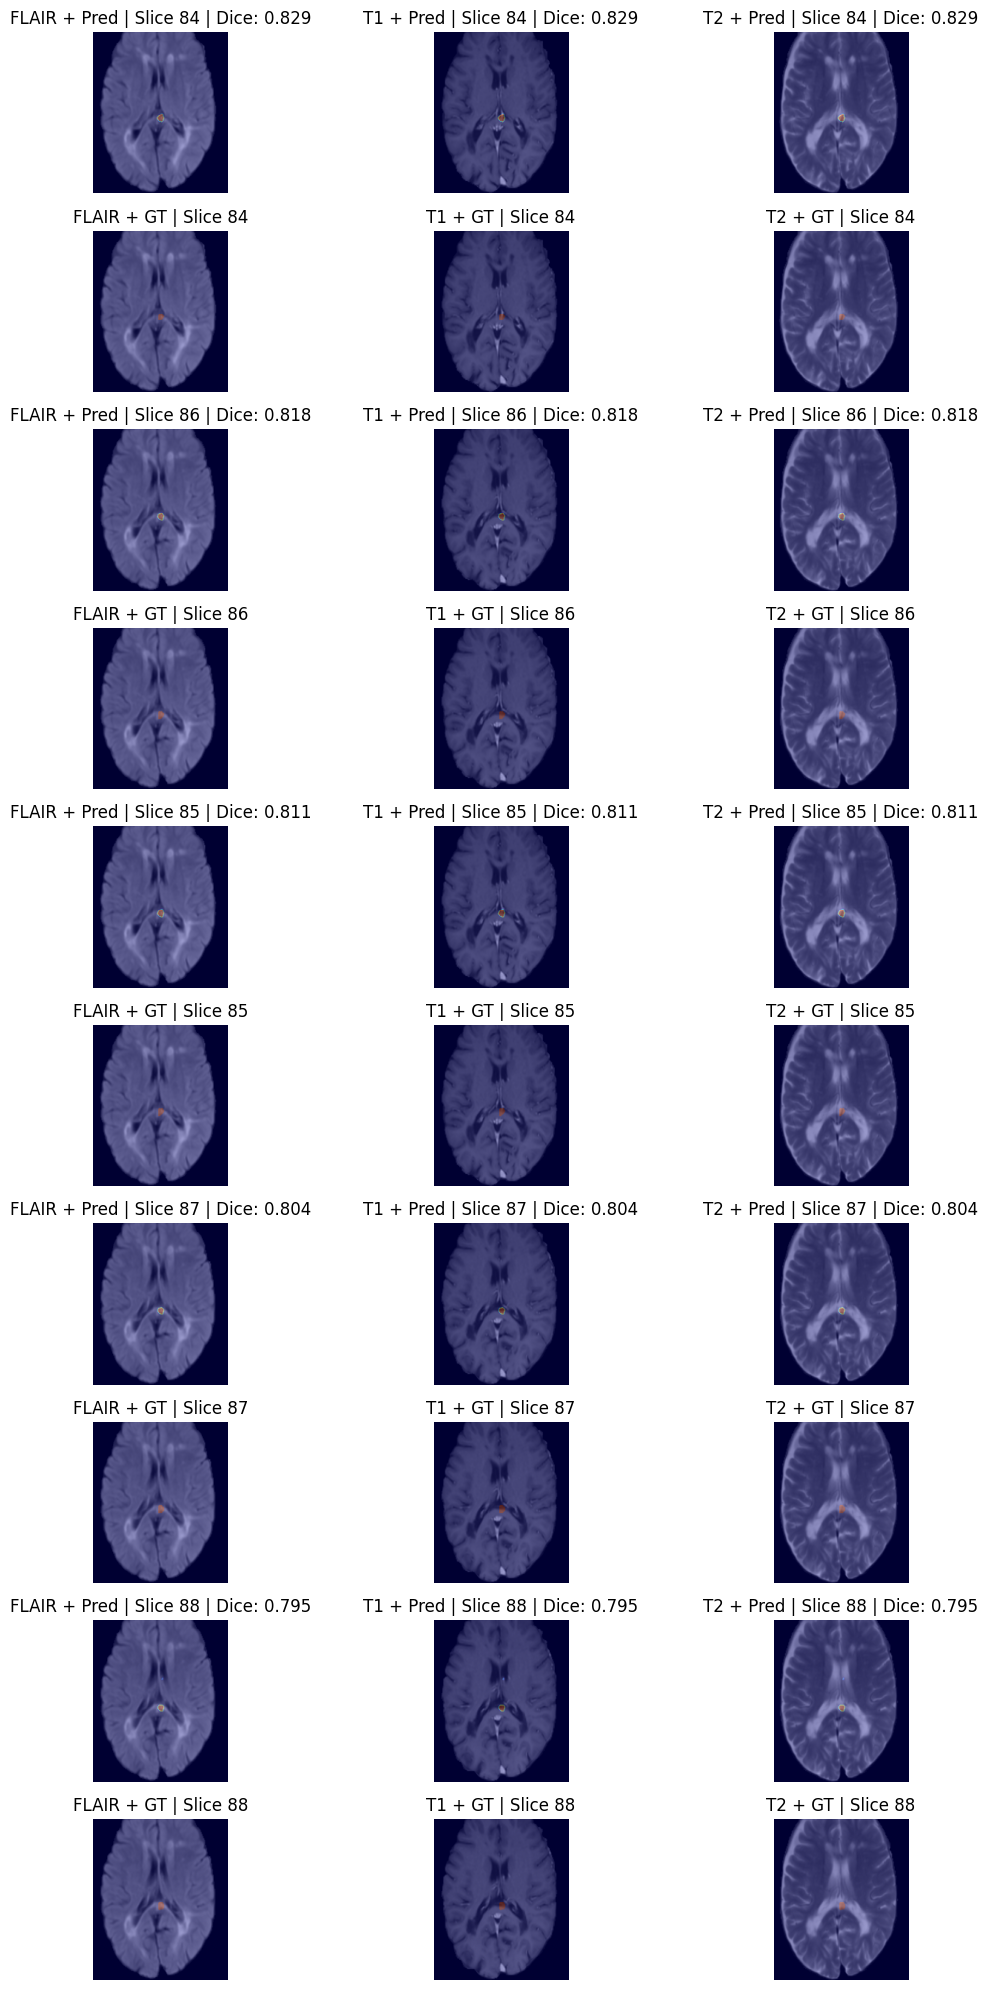

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from monai.losses import DiceLoss as MonaiDiceLoss
from scipy.ndimage import zoom
import os

# =============================
# Model Instantiation
# =============================
# Instantiate the model
segformer3dmoe = SegFormer3DMoE(
    in_channels = 3,
    sr_ratios = [4, 2, 1, 1],
    embed_dims = [32, 64, 160, 256],
    patch_kernel_size = [7, 3, 3, 3],
    patch_stride = [4, 2, 2, 2],
    patch_padding = [3, 1, 1, 1],
    mlp_ratios = [4, 4, 4, 4],
    num_experts_list = [4, 4, 6, 8],
    experts_selected_list = [2, 2, 3, 4],
    num_heads = [1, 2, 5, 8],
    depths = [2, 2, 2, 2],
    decoder_head_embedding_dim = 256,
    num_classes = 1,
    encoder_dropout = 0.05,
    decoder_dropout = 0.05,
    moe_dropout_encoder = 0.05,
    moe_dropout_decoder = 0.05
).to("cuda")

# =============================
# Model Loader
# =============================
def load_trained_model(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# =============================
# Random Test Sample Fetcher
# =============================
def get_random_sample(data_module):
    test_loader = data_module.test_dataloader()
    all_samples = list(test_loader)
    random_batch = random.choice(all_samples)
    inputs, targets = random_batch[0], random_batch[1]
    idx = random.randint(0, inputs.shape[0] - 1)
    return inputs[idx].to("cuda"), targets[idx].to("cuda")

# =============================
# Prediction Function
# =============================
def predict(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor.unsqueeze(0))  # Add batch dim
        if isinstance(output, (list, tuple)):
            output = output[0]
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float().squeeze(0)  # Remove batch dim
    return pred_mask

# =============================
# Orientation + Resampling
# =============================
def ras_to_las(volume):
    return np.flip(volume, axis=1)

def resize_volume(volume, target_shape=(182, 218, 182), order=1):
    current_shape = volume.shape
    zoom_factors = [t / c for t, c in zip(target_shape, current_shape)]
    return zoom(volume, zoom_factors, order=order)

# =============================
# Dice Per Slice
# =============================
def dice_score_per_slice(pred_mask, gt_mask):
    pred_np = pred_mask.squeeze().detach().cpu().numpy()
    gt_np = gt_mask.squeeze().detach().cpu().numpy()

    dice_scores = []
    for z in range(pred_np.shape[0]):
        p = pred_np[z].flatten()
        g = gt_np[z].flatten()
        intersection = np.sum(p * g)
        union = np.sum(p) + np.sum(g)
        dice = (2. * intersection) / (union + 1e-5)
        dice_scores.append(dice)

    return np.array(dice_scores)

# =============================
# Plotting Top Slices
# =============================
def plot_best_slices(input_tensor, prediction, ground_truth, modality_names=['FLAIR', 'T1', 'T2'], top_k=5):
    input_np = input_tensor.detach().cpu().numpy()  # Shape: (C, D, H, W)
    pred_mask = prediction.squeeze().detach().cpu().numpy()
    gt_mask = ground_truth.squeeze().detach().cpu().numpy()

    # 🧠 Reverse the previous swapaxes(1, 3) => just do it once
    input_np = input_np.swapaxes(1, 3)  # (C, W, H, D) => (C, D, H, W)

    # 🧠 Apply RAS → LAS and resizing
    input_np = np.array([resize_volume(ras_to_las(mod), (182, 218, 182)) for mod in input_np])
    pred_mask = resize_volume(ras_to_las(pred_mask), (182, 218, 182), order=1)
    gt_mask = resize_volume(ras_to_las(gt_mask), (182, 218, 182), order=1)

    # 🧠 Compute Dice scores per slice
    dice_scores = dice_score_per_slice(torch.tensor(pred_mask), torch.tensor(gt_mask))

    top_indices = np.argsort(dice_scores)[-top_k:][::-1]

    fig, axes = plt.subplots(2 * top_k, 3, figsize=(12, 4 * top_k))
    for row, z in enumerate(top_indices):
        for i in range(3):
            img = input_np[i, z]

            axes[2*row, i].imshow(img, cmap='gray')
            axes[2*row, i].imshow(pred_mask[z], cmap='jet', alpha=0.4)
            axes[2*row, i].set_title(f"{modality_names[i]} + Pred | Slice {z} | Dice: {dice_scores[z]:.3f}")
            axes[2*row, i].axis('off')

            axes[2*row+1, i].imshow(img, cmap='gray')
            axes[2*row+1, i].imshow(gt_mask[z], cmap='jet', alpha=0.4)
            axes[2*row+1, i].set_title(f"{modality_names[i]} + GT | Slice {z}")
            axes[2*row+1, i].axis('off')

    plt.tight_layout()
    plt.show()


# =============================
# Execution
# =============================
if __name__ == "__main__":
    # Load model weights
    model = load_trained_model(segformer3dmoe, "./model_checkpoints/segformer3d_moe_best_model_2.pth")

    # Prepare data module
    data_module = MSLesSegDataModule(
        root_data_dir="../data/03-SegFormer-Tensor-Data/",
        batch_size=2,
        val_split=0.2,
        num_workers=0
    )
    data_module.setup()

    # Get random sample
    input_tensor, ground_truth = get_random_sample(data_module)

    # Predict
    prediction = predict(model, input_tensor)

    # Plot
    plot_best_slices(input_tensor, prediction, ground_truth, top_k=5)


---